<a href="https://colab.research.google.com/github/Nyzl/1i/blob/master/python_twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#install the libraries
!pip -q install pandas
!pip -q install Tweepy
!pip -q install pyLDAvis

In [6]:
#import all the libs needed, including downloading the nltk resources
import tweepy
import pandas as pd
import string,re

import pyLDAvis.gensim
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt

import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet

#!export PYTHONWARNINGS="ignore"
import warnings
warnings.filterwarnings('ignore')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
#download the tweets you need and put them in a nice pandas dataframe
consumer_key = 'D3CskEgt9Q18mEmVGnMgyTWOZ'
consumer_secret = 'VsmTeE3ptSLseNnXdHHAxqZ2OTClbekZaqoygMSmrdZuqiW8Eb'
access_token = '442738667-RZb1zpW5UYI4FDQVm6P3lM5Ml8kvR2AtgqlDqXaw'
access_token_secret = 'MrIDPy3oQIRgZvz6UjNEWyfNckMNO3gmnKEdpxZnJxNbi'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)
tweets = tweepy.Cursor(api.search,q='brexit+rights', lang='en').items(1000)

data = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['Tweets'])

In [0]:
#we now haz tweets! Time to analyse

In [0]:
stop = set(stopwords.words('english'))
brexit_stop = {"rt","brexit","boris","mp","johnson","theresa","donald","tusk"}
stop.update(brexit_stop)

at_mentions = re.compile("@.*?.\b")

#adding a list for extra punctuation that has slipped through like bullets and ellipses
extra_punc = ['...','..','“','“','”','”','•','…','–']
exclude = set(string.punctuation)
exclude.update(extra_punc)
lemma = WordNetLemmatizer()

def word_list(doc):
  words = re.split(r'\W+', doc)
  words = [word.lower() for word in words]
  return words

def clean2(docs):
  mention_free = [re.sub(r'@.*?.\b', '', doc) for doc in docs]
  normalized = [" ".join(lemma.lemmatize(word) for word in word_list(doc)) for doc in mention_free]
  stop_free = [" ".join(word for word in word_list(doc) if word not in stop) for doc in normalized]
  punc_free = [["".join(letter for letter in word if letter not in exclude)for word in word_list(doc)] for doc in stop_free]
  return punc_free

def bagowords():
  words = []
  for doc in doc_clean:
    for word in doc:
      words.append(word)
  return words

docs = data['Tweets']
doc_clean = clean2(docs)
words = bagowords()

word_counts = pd.Series(' '.join(words).split()).value_counts()


small = word_counts.quantile(0.05)
large = word_counts.quantile(0.999)

uncommon = word_counts[word_counts <= max(small,3)]
common = word_counts[word_counts >= large]

def remove_top_and_tail(texts):
    clean = [[word for word in doc if word not in uncommon] for doc in texts]
    clean = [[word for word in doc if word not in common] for doc in clean]
    return clean
  
doc_clean = remove_top_and_tail(doc_clean)

words_clean = bagowords()
word_counts_clean = pd.Series(' '.join(words_clean).split()).value_counts()


In [0]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(doc_clean)
corpus = [dictionary.doc2bow(text) for text in doc_clean]

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

In [0]:
number_of_topics = 5
# Running and Training LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=number_of_topics, id2word=dictionary, passes=100)

coherence_model_lda = CoherenceModel(model=ldamodel, texts=doc_clean, dictionary=dictionary, coherence='c_uci')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Coherence Score:  -7.869041522617211


In [0]:
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(lda_display)

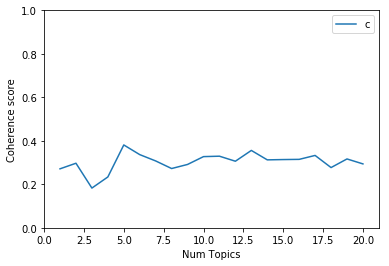

In [0]:
start = 1
#limit = 15 #@param {type:"slider", min:1, max:100, step:1}
step = 1
limit = 21
#number_of_topics = 5

def compute_coherence_values(dictionary, corpus, texts, limit, start=1, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary, passes=50)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values
  

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=doc_clean, start=start, limit=limit, step=step)

%matplotlib inline

limit=limit; start=start; step=step;
x = range(start, limit, step)
axes = plt.gca()
axes.set_xlim([0,limit])
axes.set_ylim([0,1])

plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()